In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
#https://keras.io/examples/generative/conditional_gan/#interpolating-between-classes-with-the-trained-generator

In [3]:
class ConditionalGAN(keras.Model):
    def __init__(self, noise_dim=50, 
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-5, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = False):

        super(ConditionalGAN, self).__init__()
        self.noise_dim = noise_dim
        self.data_shape = data_shape # output shape of the generator and goes to discriminator
        self.num_classes = num_classes
        self.d_optimizer = tf.keras.optimizers.Adam(d_learning_rate)
        self.g_optimizer = tf.keras.optimizers.Adam(g_learning_rate)
        self.batch_size = batch_size
        self.start_epoch = start_epoch
        self.verbose = verbose

        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

        # add number of class labels to the input channels for generator
        self.g_dim = self.noise_dim + self.num_classes

        # add the number of class labels to the input to the discriminator
        self.d_dim = self.data_shape + self.num_classes

        if (self.verbose):
            print("Generator input dim: ", self.g_dim)
            print("Dicrimination input dim: ", self.d_dim)


        # build generator and discriminator
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def build_generator(self):
        "Build the generator model"
        inputs = Input(shape=(self.g_dim,))
        hidden = Dense(64)(inputs) # 128
        hidden = LeakyReLU(alpha=0.2)(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dense(64)(hidden)
        hidden = LeakyReLU(alpha=0.2)(hidden)

        output = Dense(self.data_shape, activation="sigmoid")(hidden)
        #output = Dense(self.data_shape, activation="linear")(hidden)

        generator = Model(inputs=inputs, outputs=output, name="generator")
        generator.summary()
        return generator


    def build_discriminator(self):
        "build the discriminator model"
        d_inputs = Input(shape=(self.d_dim,))
        h = Dense(64, input_shape=(self.g_dim,))(d_inputs) 
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(64)(h) #32
        h = LeakyReLU(alpha=0.2)(h)
        h = Dropout(0.1)(h)
        h = Dense(1, activation="sigmoid")(h)
        discriminator = Model(d_inputs, h, name="discriminator")
        discriminator.summary()
        return discriminator

    def compile(self, loss_fn):
        super(ConditionalGAN, self).compile()
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_ages, one_hot_labels = data
        real_ages = tf.cast(real_ages, tf.float32)
        #print("real_ages:", real_ages[0:2])

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        age_one_hot_labels = one_hot_labels[:, None]
        print("age_one_hot_labels1:", age_one_hot_labels[0:2])

        age_one_hot_labels = tf.repeat(age_one_hot_labels, repeats=[1])
        print("age_one_hot_labels2:", age_one_hot_labels[0:2])

        age_one_hot_labels = tf.reshape(age_one_hot_labels, (-1, self.num_classes))
        age_one_hot_labels = tf.cast(age_one_hot_labels, tf.float32)
        print("age_one_hot_labels3:", age_one_hot_labels[0:2])

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_ages)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Decode the noise (guided by labels) to fake ages.
        generated_ages = self.generator(random_vector_labels)
        generated_ages= tf.cast(generated_ages, tf.float32)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here. and tf.concat is on the last dimension (-1)
        fake_ages_and_labels = tf.concat([generated_ages, age_one_hot_labels], -1)
        real_ages_and_labels = tf.concat([real_ages, age_one_hot_labels], -1) 
        combined_ages = tf.concat([fake_ages_and_labels, real_ages_and_labels], axis=0)

        # Assemble labels discriminating real from fake ages. 1 == fake, 0 == real
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # TODO: concerned that observations are ordered fake then real - do we want to concat, then shuffle, then separate?

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_ages)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.noise_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_ages = self.generator(random_vector_labels)
            fake_ages_and_labels = tf.concat([fake_ages, age_one_hot_labels], -1)
            predictions = self.discriminator(fake_ages_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

    def generate(self, n=1000, one_hot_label=[1., 0., 0.]):
        """Generate n ages for a class"""
        print("Generating: ", n, " ages for unit type: ", one_hot_label)
        input_noise = tf.random.normal((n, self.noise_dim), 0, 1)
        random_vector_labels = tf.concat([input_noise, one_hot_label], axis=1)

        ages = self.generator(random_vector_labels)

        return ages.numpy()

In [4]:
ages_unit_np = np.load("../data/eICU_age_unittype.npy", allow_pickle=True)
print('length: ', len(ages_unit_np))
print(ages_unit_np[0:5])

ages_np = np.asarray(ages_unit_np[:,0].flatten().tolist()).flatten()
print('ages length: ', len(ages_np))
#print(ages_np[0:5])

unit_np = np.asarray(ages_unit_np[:,1].flatten().tolist()).flatten()
print('unit length: ', len(unit_np))
#print(ethnicity_np[0:5])

df_ages = pd.DataFrame(zip(ages_np, unit_np), columns=['age','unit'])
print(df_ages.shape)
print(df_ages.groupby('unit').count())

# create data set without 90 or greater since that was a category flattened
print("==" * 30)
print("FILTERED:")
df_ages_filtered = df_ages.query("age < 90")
df_ages_filtered['unit_code'] = df_ages_filtered['unit'].astype('category').cat.codes
print(df_ages_filtered.groupby('unit').count())


mean_age_filtered = df_ages_filtered.age.mean()
std_age_filtered =  df_ages_filtered.age.std()
min_age_filtered =  df_ages_filtered.age.min()
max_age_filtered =  df_ages_filtered.age.max()

print("mean age: ", mean_age_filtered)
print("std age: ", np.round(std_age_filtered,3))
print("min age: ", min_age_filtered)
print("max age: ", max_age_filtered)

scaled_ages_filtered = [(x - min_age_filtered)/(max_age_filtered - min_age_filtered) for x in df_ages_filtered['age']]
all_ages = np.reshape(scaled_ages_filtered, (-1, 1))

all_labels = keras.utils.to_categorical(df_ages_filtered['unit_code'], 3)


print(scaled_ages_filtered[0:5])
print(np.array(all_labels[0:5]))
print(f"Shape of ages: {all_ages.shape}")

print(f"Shape of labels: {all_labels.shape}")

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_ages, all_labels))
dataset = dataset.shuffle(buffer_size=200).batch(64)
#list(dataset.as_numpy_iterator())
#for element in dataset:
#    print(element)


length:  250
[[(59,) ('CTICU',)]
 [(55,) ('CTICU',)]
 [(72,) ('Cardiac ICU',)]
 [(49,) ('CTICU',)]
 [(49,) ('CTICU',)]]
ages length:  250
unit length:  250
(250, 2)
             age
unit            
CSICU         65
CTICU         52
Cardiac ICU  133
FILTERED:
             age  unit_code
unit                       
CSICU         65         65
CTICU         52         52
Cardiac ICU  133        133
mean age:  62.472
std age:  14.503
min age:  21
max age:  89
[0.5588235294117647, 0.5, 0.75, 0.4117647058823529, 0.4117647058823529]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
Shape of ages: (250, 1)
Shape of labels: (250, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

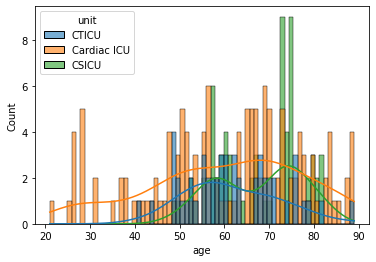

In [5]:
sns.histplot(data=df_ages, x='age', hue='unit', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

In [6]:
# one hot encode the ethnicity
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df_ages[['unit']]).toarray())

#merge one-hot encoded columns back with original DataFrame
final_df = df_ages.join(encoder_df)
final_df.columns = ['age', 'unit', 'CSICU', 'CTICU', 'Cardiac_ICU']
final_df.tail()

,age,unit,CSICU,CTICU,Cardiac_ICU
245,52,CTICU,0.0,1.0,0.0
246,52,Cardiac ICU,0.0,0.0,1.0
247,52,Cardiac ICU,0.0,0.0,1.0
248,41,CTICU,0.0,1.0,0.0
249,41,Cardiac ICU,0.0,0.0,1.0


In [7]:
df_ages.groupby('unit').describe()

age                                                     
             count       mean        std   min    25%   50%   75%   max
unit                                                                   
CSICU         65.0  67.646154   9.416460  49.0  59.00  70.0  75.0  82.0
CTICU         52.0  61.692308  10.351733  41.0  54.75  60.0  69.0  89.0
Cardiac ICU  133.0  60.248120  17.145724  21.0  50.00  63.0  73.0  89.0

## Plan
1. Create the kde for each unit type (class)
2. Sample from the kde on each training round per class
    1. sample the same number of points as we have per class (e.g. 65 samples from the CSICU class)
3. instead of training valid and fake spearately - intermingle and train together

In [8]:
cgan = ConditionalGAN(noise_dim=50,
                 data_shape=1,
                 num_classes=3, 
                 d_learning_rate=1e-5, 
                 g_learning_rate=1e-6, 
                 batch_size=64, 
                 start_epoch=0,
                 verbose = False)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)              

In [9]:
cgan.compile(loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

In [10]:
cgan.fit(dataset, epochs=15000, verbose=False)

age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 3), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 3), dtype=float32)


C:\Users\dianam\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


age_one_hot_labels1: Tensor("strided_slice_1:0", shape=(None, 1, 3), dtype=float32)
age_one_hot_labels2: Tensor("strided_slice_2:0", shape=(None,), dtype=float32)
age_one_hot_labels3: Tensor("strided_slice_3:0", shape=(None, 3), dtype=float32)


In [ ]:
"""Generate n ages for a class"""
print("Generating: ", 65, " ages for unit type: [1., 0., 0.]")

age_one_hot_labels = tf.repeat([[1., 0., 0.]],65, axis=0)

input_noise = tf.random.normal((65, cgan.noise_dim), 0, 1)
random_vector_labels = tf.concat([input_noise, age_one_hot_labels], axis=1)

ages = cgan.generator(random_vector_labels)

inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

print("Generated Ages:")
print("min: ", np.min(inv_gen_ages))
print("mean: ", np.mean(inv_gen_ages))
print("max: ", np.max(inv_gen_ages))
print("stdv: ", np.std(inv_gen_ages))

df_ages_class = final_df.query("unit == 'CSICU'")

print("True Ages:")
print("min: ", np.min(df_ages_class.age))
print("mean: ", np.mean(df_ages_class.age))
print("max: ", np.max(df_ages_class.age))
print("stdv: ", np.std(df_ages_class.age))


sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
plt.title('CSICU Ages')
plt.legend()
plt.show

In [ ]:
"""Generate n ages for a class"""
print("Generating: ", 52, " ages for unit type: [0., 1., 0.]")

age_one_hot_labels = tf.repeat([[0., 1., 0.]],52, axis=0)

input_noise = tf.random.normal((52, cgan.noise_dim), 0, 1)
random_vector_labels = tf.concat([input_noise, age_one_hot_labels], axis=1)

ages = cgan.generator(random_vector_labels)

inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

print("Generated Ages:")
print("min: ", np.min(inv_gen_ages))
print("mean: ", np.mean(inv_gen_ages))
print("max: ", np.max(inv_gen_ages))
print("stdv: ", np.std(inv_gen_ages))

df_ages_class = final_df.query("unit == 'CTICU'")

print("True Ages:")
print("min: ", np.min(df_ages_class.age))
print("mean: ", np.mean(df_ages_class.age))
print("max: ", np.max(df_ages_class.age))
print("stdv: ", np.std(df_ages_class.age))


sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
plt.title('CTICU Ages')
plt.legend()
plt.show

In [ ]:
"""Generate n ages for a class"""
print("Generating: ", 133, " ages for unit type: [0., 0., 1.]")

age_one_hot_labels = tf.repeat([[0., 0., 1.]],133, axis=0)

input_noise = tf.random.normal((133, cgan.noise_dim), 0, 1)
random_vector_labels = tf.concat([input_noise, age_one_hot_labels], axis=1)

ages = cgan.generator(random_vector_labels)

inv_gen_ages = [(val * (max_age_filtered-min_age_filtered)) + min_age_filtered for val in ages.numpy().flatten()]

print("Generated Ages:")
print("min: ", np.min(inv_gen_ages))
print("mean: ", np.mean(inv_gen_ages))
print("max: ", np.max(inv_gen_ages))
print("stdv: ", np.std(inv_gen_ages))

df_ages_class = final_df.query("unit == 'Cardiac ICU'")

print("True Ages:")
print("min: ", np.min(df_ages_class.age))
print("mean: ", np.mean(df_ages_class.age))
print("max: ", np.max(df_ages_class.age))
print("stdv: ", np.std(df_ages_class.age))


sns.histplot(inv_gen_ages, bins=70, label='GAN', kde=True,)
sns.histplot(df_ages_class.age, bins=70, color='orange', label='Truth', alpha=0.3, kde=True,)
plt.title('Cardiac ICU Ages')
plt.legend()
plt.show

In [ ]:
# show total distribution
